In [16]:
import os
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
# Your client credentials
client_id = os.environ['SH_CLIENT_ID']
client_secret = os.environ['SH_CLIENT_SECRET']
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)
# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

In [2]:
import json
import geojson
import shapely.wkt
from shapely import geometry
from xcube.core.geom import mask_dataset_by_geometry
import shapely.geometry
import IPython.display
f=open('countries.json')
data=json.load(f)
print(data['features'][0]['id'])
final=dict()
for i in range(0,len(data['features'])):
    #print(data['features'][i]['id'])
    final[data['features'][i]['id']]=data['features'][i]['geometry']['coordinates']

AFG


In [33]:
germany=geometry.Polygon(final['USA'][5][0])
germany_area = shapely.wkt.loads(germany.wkt)
germany_gj = geojson.Feature(geometry=germany_area, properties={})
IPython.display.GeoJSON(germany_gj)

<IPython.display.GeoJSON object>

In [34]:
import requests

response = requests.post('https://shservices.mundiwebservices.com/api/v1/process',
  headers={
      "Authorization" : "Bearer %s"%(token['access_token'])},
  json={
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            },
            "geometry": germany_gj.geometry
        },
        "data": [
            {
                "type": "sentinel-5p-l2",
                "dataFilter": {
                    "timeRange": {
                        "from": "2018-12-30T00:00:00Z",
                        "to": "2018-12-31T00:00:00Z"
                    },
                  "timeliness": "NRTI"
                }
            }
        ]
    },
    "output": {
        "width": 512,
        "height": 512
    },"evalscript":"""
//VERSION=3
function setup() {
  return {
    input: ["NO2", "dataMask"],
    output: { bands:  4 }
  }
}

const minVal = 0.0
const maxVal = 0.0001
const diff = maxVal - minVal

const rainbowColors = [
    [minVal, [0, 0, 0.5]],
    [minVal + 0.125 * diff, [0, 0, 1]],
    [minVal + 0.375 * diff, [0, 1, 1]],
    [minVal + 0.625 * diff, [1, 1, 0]],
    [minVal + 0.875 * diff, [1, 0, 0]],
    [maxVal, [0.5, 0, 0]]
]

const viz = new ColorRampVisualizer(rainbowColors)

function evaluatePixel(sample) {
    var rgba= viz.process(sample.NO2)
    rgba.push(sample.dataMask)
    return rgba
}
"""
})


In [35]:
response.content

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x06\x00\x00\x00\xf4x\xd4\xfa\x00\x00\x07\x9cIDATx^\xed\xc81\x01\xc0@\x10\x04\xa1\x93\xfe\xd2#`\x1dL(h\xb8ww\x00\xc0\xbfL\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x01\x00\xf4M\x00\x00}\x13\x00@\xdf\x04\x00\xd07\x0

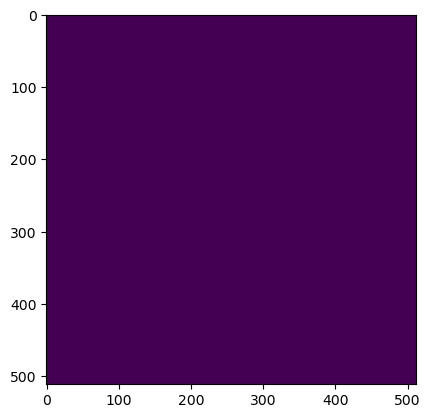

<AxesSubplot:>

In [36]:
# Let us save the response as file
file = open("esa_tsm.png", "wb")
file.write(response.content)
file.close()

# And now we can visualize the raster with rasterio or you can manipulate it in any way you like
import rasterio
from rasterio.plot import show

fp = r'esa_tsm.png'
img = rasterio.open(fp)
show(img.read(1))